In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

pi = np.pi

In [362]:
DIM_RES = 10
DIM_Q = 2
A = destroy(DIM_RES)
WR = 7.062e3  # GHz frequency of resonator
WQ = 5.092e3  # GHz frequency of qubit
G = 102.9  # MHz coupling strength
K = 5.35  # MHz kappa, photon decay rate
X = 0.16*5.35  # MHz kai, dispersive shift
D = 0.5e6 # Kronecker Delta in the Equation, treating it as 1 for now
P1PH = 36.1  # MHz power required to maintain a population of one photon
PNORM = 4.0  # no units (number of photons)
MAX_AMP = np.sqrt(P1PH*PNORM)  # Constant determined by the AWG in the lab

KERR = 2*G**4*D*( 3*WQ**4 + 2*WQ**2*WR**2 + 3*WR**4 )/( WQ**2 - WR**2 )**4
print(KERR)

T_INITIAL = 0.0
T_FINAL = 1.0
LENGTH = 200
ACTUAL_START = (T_FINAL - T_INITIAL) / LENGTH + T_INITIAL
T_LIST = np.linspace(T_INITIAL, T_FINAL, LENGTH + 1)

H_JC = (
    WR * tensor(A.dag() * A, qeye(DIM_Q))
    + tensor(qeye(DIM_RES), WQ * sigmaz() / 2)
    + X * tensor(A.dag() * A, sigmaz())
    + X / 2 * tensor(qeye(DIM_RES), sigmaz())
)
H_K = tensor(KERR*(A.dag()*A)**2, qeye(DIM_Q))
H_D1 = tensor(A.dag(), qeye(DIM_Q))
H_D2 = tensor(A, qeye(DIM_Q))

INITIAL_STATE = tensor(
    coherent(DIM_RES, np.sqrt(PNORM)), fock(2, 0)
)  # second input in coherent squared gives the init num of photons

NSTEPS = 2000
OPTS = Options(rhs_reuse=True, nsteps=NSTEPS)

4.115614718047456


In [380]:
times = np.array([-0.5, -0.7])
amplitudes = np.array([-1, 1])

args = {"A1": amplitudes[0]*MAX_AMP, "A2": amplitudes[1]*MAX_AMP, "WR": WR}

H_first = [H_JC + H_K, [H_D1, "A1*exp(-1j*WR*t)"], [H_D2, "A1*exp(1j*WR*t)"]]
H_second = [H_JC + H_K, [H_D1, "A2*exp(-1j*WR*t)"], [H_D2, "A2*exp(1j*WR*t)"]]

#H_first = [H_JC, [H_D1, "A1"], [H_D2, "A1"]]
#H_second = [H_JC, [H_D1, "A2"], [H_D2, "A2"]]

first_time = int((times[0] + 1)*(LENGTH - 2)/2)
second_time = int((times[1] + 1)*(LENGTH - 2)/2)

In [383]:
result_first = mesolve(
    H_first,
    INITIAL_STATE,
    T_LIST[0:first_time],
    c_ops=[np.sqrt(K) * tensor(A, qeye(DIM_Q))],
    e_ops=[tensor(A.dag() * A, qeye(DIM_Q))],
    args=args,
    options=Options(nsteps=NSTEPS)
)

initial_state = tensor(
    coherent(DIM_RES, np.sqrt(result_first.expect[0][-1])), fock(2, 0)
)  # second input in coherent squared gives the init num of photons

result_second = mesolve(
    H_second,
    initial_state,
    T_LIST[first_time - 1:first_time + second_time],
    c_ops=[np.sqrt(K) * tensor(A, qeye(DIM_Q))],
    e_ops=[tensor(A.dag() * A, qeye(DIM_Q))],
    args=args,
    options=Options(nsteps=NSTEPS),
)

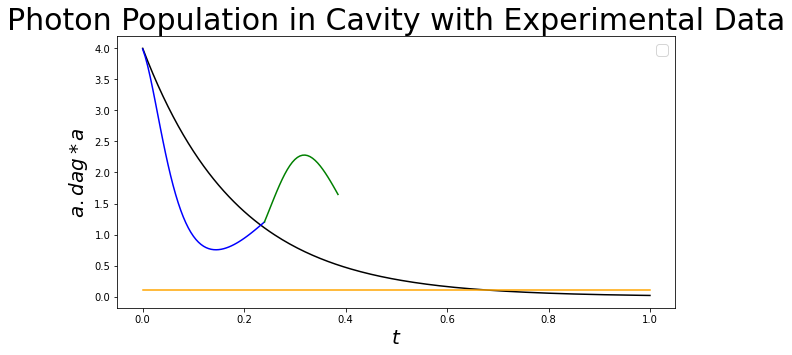

In [384]:
nat_decay = PNORM*np.exp(-K*T_LIST)
min_line = np.zeros_like(T_LIST) + 0.1

fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(T_LIST, nat_decay, color="black")
axes.plot(result_first.times, result_first.expect[0], color="blue")
axes.plot(result_second.times, result_second.expect[0], color="green")
axes.plot(T_LIST, min_line, color="orange")
axes.set_title(
    "Photon Population in Cavity with Experimental Data", fontsize=30
)
axes.set_xlabel(r"$t$", fontsize=20)
axes.set_ylabel(r"$a.dag*a$", fontsize=20)
axes.legend(fontsize=15)
plt.show()